In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import calendar

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data


import dask
from dask.distributed import Client


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:38385 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 67.47 GB


In [3]:
def get_plot_title(cmod, custom_names, E):
    if cmod in custom_names:
        new_title = custom_names[cmod]
    elif cmod in E.model.keys():
        new_title = E.model[cmod]['model_label']
    else:
        new_title = cmod
    return new_title

In [4]:
def add_subplot_title(cmod, custom_names, E, ax=None):

    ax.set_title(get_plot_title(cmod, custom_names, E))

In [5]:
E = ed.EsioData.load()
# Directories
all_models=['rasmesrl']
runType='forecast'


In [6]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['SIP']}
# Some models not to include
MME_NO = ['hcmr']

### Time configuration

In [7]:
# Target time range
valid_start = np.datetime64('2019-09-01')
valid_end = np.datetime64('2019-09-30')

# SIO Report Year_Month
cyear = '2019'
cmonth = 'June'
# cmonth = 'July'
# cmonth = 'August'

# Models that create an Ensemble using different init days
it_target_size = {'usnavysipn':10, 'ukmetofficesipn':21} # Define the number of past days to use TODO: assumes daily inits

In [76]:
# Get recent observations
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True)

In [ ]:
# Define custom mod names, okay if not used
# https://docs.google.com/document/d/1eztVwPllCKDYOXbZ4nBt3j-3aK3YeOfAf6TPSb-86fQ/edit 
custom_names = {'usnavysipn':'Navy ESPC','gfdlsipn':'NOAA GFDL','noaasipn':'NCEP CPC','uclsipn':'UCL',
                'ukmetofficesipn':'Met. Office','ecmwfsipn':'ECMWF-c3s',
                'gmao':'NASA GMAO','seansipn':'NSIDC,\nCU Boulder', 'piomas':'UW APL',
                'awispin':'AWI\nConsortium','szapirosipn':'MPAS-CESM',
                'nmisipn':'Norwegian\nMet. Inst.','fgoalssipn':'IAP LASG',
                'nicosipn':'Sun','Xiaojun':'Lamont','modcansipns_4':'Modified\nCanSIPS'}


In [143]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)
# Load in regional data
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

In [144]:
# Define models to plot and not to plot
No_No_models = ['MME_NEW','piomas','MME','modcansipns_3','modcansipns_4','ecmwfsipn','usnavygofs',
                   'szapirosipn','noaasipn_ext','rasmesrl','uclsipn','noaasipn','yopp','nicosipn']
non_SIPN_Report_models  = ['ecmwf','ukmo','kma','ncep','usnavyncep','metreofr','dampedAnomalyTrend'] # Models like s2s
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if np.any(x not in No_No_models) ] # remove some models
models_2_plot = [x for x in models_2_plot if np.any(x not in non_SIPN_Report_models) ] # remove some more models
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models
models_2_plot

['gfdlsipn', 'ukmetofficesipn', 'usnavysipn', 'awispin']

In [145]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

### Load in User submited SIP data

In [146]:
user_sip = [] # variable to store user submitted (regridded) SIP data
r_yr_mon = cyear+'_'+cmonth

mon_2_int = {v: k for k,v in enumerate(calendar.month_name)}

### npssipn (RASM)

In [147]:
# not in 2019 yet
cmod = 'RASM'
if r_yr_mon=='2019_June':
    sip_f = None
elif r_yr_mon=='2019_July':
    sip_f = None
    #sip_f = '/home/disk/sipn/upload/npssipn/forecast/Forecast/RASM_Sep2019_Julyreportdata.nc'
elif r_yr_mon=='2019_August':
    sip_f = None
    #sip_f = '/home/disk/sipn/upload/npssipn/forecast/Forecast/RASM_Sep2019_Aug_reportdata.nc'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")

if sip_f:
    # Open
    ds_user = xr.open_dataset(sip_f)
    sip_f = None

    # Regrid/format to sipn
    ds_user.rename({'lat':'nj', 'long':'ni','longitude':'lon','latitude':'lat'}, inplace=True);
    ds_user.set_coords(['lat','lon'], inplace=True)
    # Select SIP
    da_in = ds_user.SIP_ID
    mask = ds_user.Grid_Area.notnull()
    da_in = da_in.where(mask)

    # Calculate regridding matrix
    regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
    # Regrid 
    da_out = regridder(da_in)
    # Remove weight file
    regridder.clean_weight_file() 
    # da_in.plot()
    # plt.figure()
    # da_out.plot()

    # Store in dict of user submited SIP
    da_out.coords['model'] = cmod
    da_out = da_out.expand_dims('model')
    da_out.coords['init_date'] = xr.DataArray(np.array([np.datetime64('2018-08-01')]), 
                                              dims='model', coords={'model':da_out.model})
    user_sip.append(da_out)

### cansips (Mod CanSIPS)

<xarray.Dataset>
Dimensions:    (lat: 50, lon: 360, time: 1)
Dimensions without coordinates: lat, lon, time
Data variables:
    latitude   (lat) float32 ...
    longitude  (lon) float32 ...
    reftime    (time) datetime64[ns] ...
    sip        (time, lat, lon) float32 ...
Attributes:
    comment:  Data interpolated onto a 1 deg x 1 deg regular grid
Create weight file: nearest_s2d_50x360_304x448.nc
Remove file nearest_s2d_50x360_304x448.nc


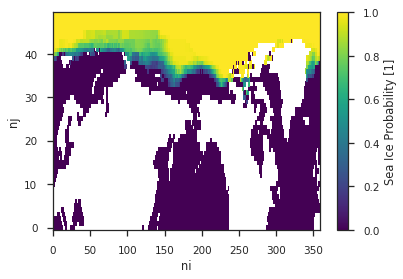

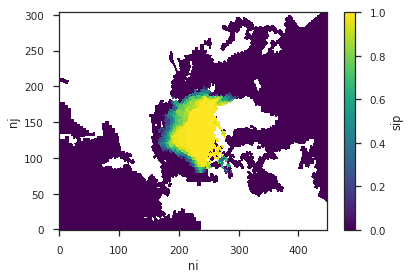

In [148]:
cmod = 'modcansipns_4'  # provides sip

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/upload/escersipn/forecast/Modified_CanSIPS_fields_postprocessed/sip_cal_i2019m06_Mod_CanSIPS.nc'
    itstr = '2019-06-01'
elif r_yr_mon=='2019_July':
    sip_f='/home/disk/sipn/upload/'
    itstr = '2019-07-01'
elif r_yr_mon=='2019_August':
    sip_f='/home/disk/sipn/upload/'
    itstr = '2019-07-01'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")   
    
ds_user = xr.open_dataset(sip_f)
sip_f = None
print(ds_user)
ds_user.rename({'lat':'nj', 'lon':'ni','longitude':'lon','latitude':'lat'}, inplace=True);
ds_user.set_coords(['lat','lon'], inplace=True)
# Select SIP
da_in = ds_user.sip.isel(time=0)
#print(da_in)

# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
da_in.plot()
plt.figure()
da_out.plot()
#print(da_out)
maska = xr.DataArray(da_out.values,dims=['nj','ni'])
never_ice = maska.isnull()

da_save = da_out

# Store in dict of user submited SIP
da_out.coords['model'] = cmod
da_out = da_out.expand_dims('model')
da_out.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                          dims='model', coords={'model':da_out.model})
user_sip.append(da_out)

## NASA GMAO

<xarray.Dataset>
Dimensions:    (x: 304, y: 448)
Coordinates:
  * y          (y) float32 1.0 2.0 3.0 4.0 5.0 ... 444.0 445.0 446.0 447.0 448.0
  * x          (x) float32 1.0 2.0 3.0 4.0 5.0 ... 300.0 301.0 302.0 303.0 304.0
Data variables:
    IFD        (x, y) float32 ...
    stdIFD     (x, y) float32 ...
    SIP        (x, y) float32 ...
    HICE_init  (x, y) float32 ...
    AICE_av    (x, y) float32 ...
    LAT        (x, y) float32 ...
    LON        (x, y) float32 ...


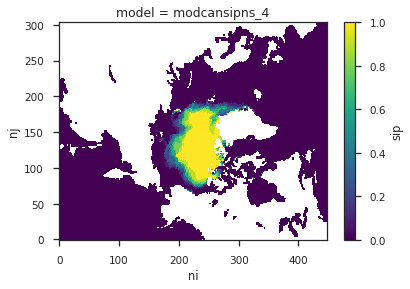

<Figure size 432x288 with 0 Axes>

In [149]:
cmod = 'gmao' # provides SIP

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/nicway/data/model/gmao/nasa_gmao_Sep2019_Junedata.nc4'
    itstr = '2019-06-01'
elif r_yr_mon=='2019_July':
    sip_f=None
    itstr = '2019-07-01'
elif r_yr_mon=='2019_August':
    sip_f=None
    itstr = '2019-08-01'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    ds_user = xr.open_dataset(sip_f)
    ds_user=ds_user.transpose('x','y')

    print(ds_user)
    da = xr.DataArray(ds_user.SIP.values,dims=['nj','ni'])

    da.coords['lon'] = da_save.lon  # these are the lat and lon from can sips
    da.coords['lat'] = da_save.lat
    da.name = 'sip'
    da.plot()
    plt.figure()

    # Store in dict of user submited SIP
    # Store in dict of user submited SIP
    da.coords['model'] = cmod
    da = da.expand_dims('model')
    da.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                            dims='model', coords={'model':da.model})
    user_sip.append(da)

## Fgoals

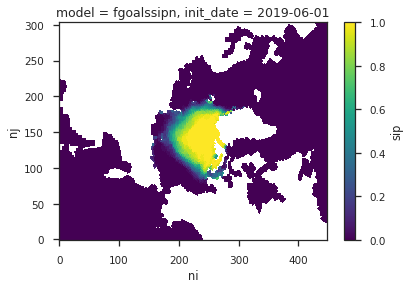

<Figure size 432x288 with 0 Axes>

In [150]:
cmod = 'fgoalssipn'
# daily freq of sic (0,1) 40 ens member so compute Sep SIC and compute binary ice presence = SIP then avg across ens
Update_FGOALS = False  # only do when needed since very slow
#Update_FGOALS = True  # only do when needed since very slow

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/F1.2-20190601-*.cice.h1.2019-09*.nc'
    itstr = '2019-06-01' 
elif r_yr_mon=='2019_July':
    sip_f=None
    itstr = '2019-07-01'
    # must fix the slice in itime below for other months
elif r_yr_mon=='2019_August':
    sip_f=None
    itstr = '2019-08-01'
    # must fix the slice in itime below for other months
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    if Update_FGOALS:
        da_all = []
        for ens in np.arange(1,41,1):
            # read in daily data for each ens and avg to monthly sic and append to one big data array
            fens = '/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/F1.2-20190601-'+str(ens).zfill(2)+'.cice.h1.2019-09*.nc'
            ds_model = xr.open_mfdataset(fens, 
                            chunks={'time': 1, 'nj': 112, 'ni': 320}, 
                                             concat_dim='time', autoclose=True, parallel=True)
            da=ds_model.aice_d
            da=da.mean(dim='time')
            da.coords['ensemble'] = ens
            da = da.expand_dims('ensemble')
            da_all.append(da)

        da_all = xr.concat(da_all, dim='ensemble')
        da_all.name = 'sic'
        da_all.coords['lon'] = da_all.TLON
        da_all.coords['lat'] = da_all.TLAT
        da_all = da_all.drop(['TLAT','TLON'])
        da_all = da_all/100 # percent to fraction
        print(da_all)

            # Calculate regridding matrix on Sep mean SIC
        regridder = xe.Regridder(da_all, obs_grid, method, periodic=False)
        # Regrid 
        da_out = regridder(da_all)
        # Remove weight file
        regridder.clean_weight_file() 
        da_out.name = 'sic'
        sip = da_out
        sip = (sip>0.15).where(sip.notnull())
        sip = sip.mean(dim='ensemble')
        sip.name = 'sip'

        da_all.mean(dim='ensemble').plot()
        plt.figure()
        da_out.mean(dim='ensemble').plot()
        plt.figure()

        # Store in dict of user submited SIP
        sip.coords['model'] = cmod
        sip = sip.expand_dims('model')
        sip.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                                  dims='model', coords={'model':sip.model})
        sip.to_netcdf('/home/disk/sipn/nicway/data/model/fgoalssipn/metric/'+cyear+'_'+cmonth+'SIP.nc')
    else:
        sip=xr.open_mfdataset('/home/disk/sipn/nicway/data/model/fgoalssipn/metric/'+cyear+'_'+cmonth+'SIP.nc')
        sip=sip.sip
        
    sip.plot()
    plt.figure()
    user_sip.append(sip)
    

## PIOMAS

Create weight file: nearest_s2d_120x360_304x448.nc


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Remove file nearest_s2d_120x360_304x448.nc


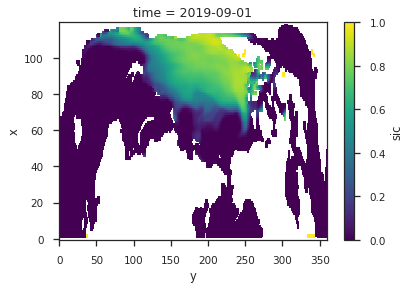

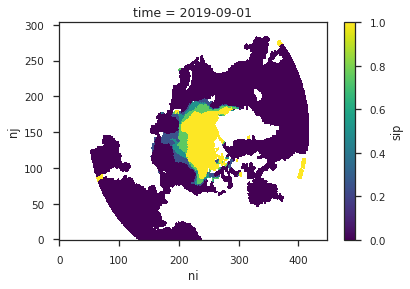

<Figure size 432x288 with 0 Axes>

In [151]:
cmod = 'piomas'

#20190601a.nc  20190601b.nc  20190601c.nc  20190601d.nc
if r_yr_mon=='2019_June':
    sip_a = '/home/disk/sipn/upload/aplsipn/forecast/2019_June/20190601a.nc'
    sip_b = '/home/disk/sipn/upload/aplsipn/forecast/2019_June/20190601b.nc'
    sip_c = '/home/disk/sipn/upload/aplsipn/forecast/2019_June/20190601c.nc'
    sip_d = '/home/disk/sipn/upload/aplsipn/forecast/2019_June/20190601d.nc'
    itstr = '2019-06-01'
elif r_yr_mon=='2019_July':
    sip_a=None
    itstr = '2019-07-01'
    # must fix the slice in itime below for other months
elif r_yr_mon=='2019_August':
    sip_a=None
    itstr = '2019-08-01'
    # must fix the slice in itime below for other months
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_a:
    da_all = []
    
    ens = 1
    ds_user = xr.open_dataset(sip_a)
    da = ds_user.sic.isel(time=3)
    da.coords['ensemble'] = ens
    da = da.expand_dims('ensemble')
    da_all.append(da)

    ens = 2
    ds_user = xr.open_dataset(sip_b)
    da = ds_user.sic.isel(time=3)
    da.coords['ensemble'] = ens
    da = da.expand_dims('ensemble')
    da_all.append(da)

    ens = 3
    ds_user = xr.open_dataset(sip_c)
    da = ds_user.sic.isel(time=3)
    da.coords['ensemble'] = ens
    da = da.expand_dims('ensemble')
    da_all.append(da)

    ens = 4
    ds_user = xr.open_dataset(sip_d)
    da = ds_user.sic.isel(time=3)
    da.coords['ensemble'] = ens
    da = da.expand_dims('ensemble')
    da_all.append(da)

    da_all = xr.concat(da_all, dim='ensemble')
    
    da_all.coords['lon'] = da_all.Longitude
    da_all.coords['lat'] = da_all.Latitude
    
            # Calculate regridding matrix on Sep mean SIC
    regridder = xe.Regridder(da_all, obs_grid, method, periodic=False)
    # Regrid 
    sip = regridder(da_all)
    sip = (sip>0.15).where(sip.notnull())
    sip.name = 'sip'
    sip=sip.mean(dim='ensemble')

    regridder.clean_weight_file() 

    da_all.mean(dim='ensemble').plot()
    plt.figure()
    sip.plot()
    plt.figure()

    sip=sip.drop(['time'])

        # Store in dict of user submited SIP
    sip.coords['model'] = cmod
    sip = sip.expand_dims('model')
    sip.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                              dims='model', coords={'model':sip.model})

    user_sip.append(sip)


## Norwegian Met Institute

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Create weight file: nearest_s2d_242x322_304x448.nc
Remove file nearest_s2d_242x322_304x448.nc


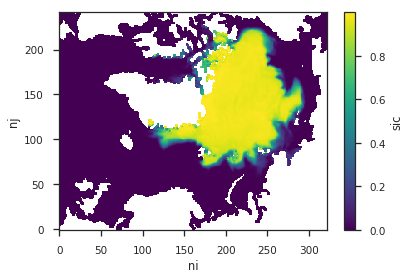

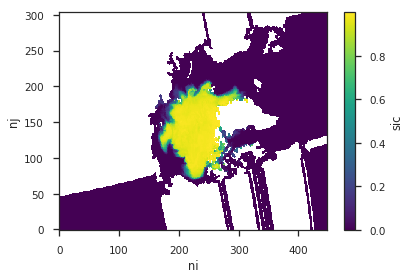

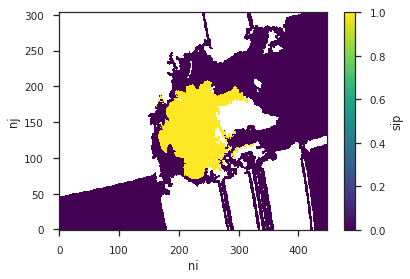

In [152]:
cmod = 'nmisipn'
# daily freq of sic (0,1) one ens member so compute Sep SIC and compute binary ice presence = SIP

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/nicway/data/model/nmisipn/forecast/native/metno-sparse-2019-06.nc'
    itstr = '2019-06-01'
elif r_yr_mon=='2019_July':
    sip_f=None
    itstr = '2019-07-01'
    # must fix the slice in itime below for other months
elif r_yr_mon=='2019_August':
    sip_f=None
    itstr = '2019-08-01'
    # must fix the slice in itime below for other months
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    ds_user = xr.open_dataset(sip_f)
    ds_user = ds_user.aice_d
    ds_user = ds_user.isel(time=slice(109,139))
    ds_user = ds_user.mean(dim='time')
    ds_user.name = 'sic'
    ds_user.coords['lon'] = ds_user.TLON
    ds_user.coords['lat'] = ds_user.TLAT
    da_in = ds_user.drop(['TLAT','TLON'])

        # Calculate regridding matrix on Sep mean SIC
    regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
    # Regrid 
    da_out = regridder(da_in)
    # Remove weight file
    regridder.clean_weight_file() 
    
    sip = da_out
    sip = (sip>0.15).where(sip.notnull())
    
    #    sip = sip.where(never_ice, other=sip) # made no differenece
    #print(da_out)
    #print(sip)
    sip.name = 'sip'

    da_in.plot()
    plt.figure()
    da_out.plot()
    plt.figure()
    sip.plot()

    # Store in dict of user submited SIP
    sip.coords['model'] = cmod
    sip = sip.expand_dims('model')
    sip.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                              dims='model', coords={'model':sip.model})
    user_sip.append(sip)
    

### Sean H.

<xarray.DataArray 'model' (model: 1)>
array(['seansipn'], dtype='<U8')
Coordinates:
  * model      (model) <U8 'seansipn'
    init_date  (model) datetime64[ns] 2019-06-01


<Figure size 432x288 with 0 Axes>

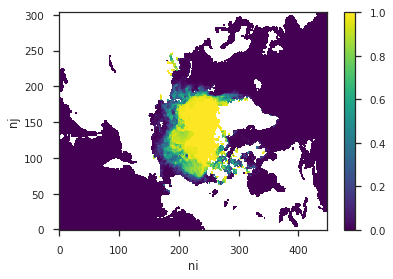

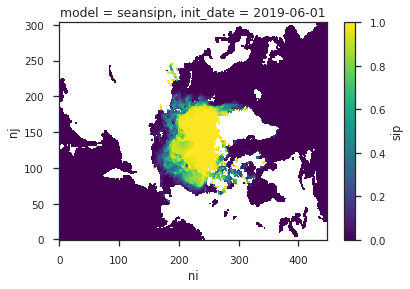

<Figure size 432x288 with 0 Axes>

In [153]:
cmod = 'seansipn'

# apparently this is SIP
if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/upload/seansipn/forecast/2019/June/2019_Forecast_Made_in_June.nc'
    itstr = '2019-06-01'
elif r_yr_mon=='2019_July':
    sip_f=''
    itstr = '2019-07-01'
elif r_yr_mon=='2019_August':
    sip_f=''
    itstr = '2019-08-01'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

ds_user = xr.open_dataset(sip_f)
ds_user=ds_user.transpose('x','y')
da = xr.DataArray(np.flip(ds_user.Band1.values,1),dims=['nj','ni'])
da.plot()
plt.figure()

da.name = 'sip'

da.coords['lon'] = da_save.lon  # these are the lat and lon from can sips
da.coords['lat'] = da_save.lat

# Store in dict of user submited SIP
da.coords['model'] = cmod
da = da.expand_dims('model')
da.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                        dims='model', coords={'model':da.model})
user_sip.append(da)

print(da.model)
da.plot()
plt.figure()


### Xioajun

Create weight file: nearest_s2d_101x180_304x448_peri.nc
Remove file nearest_s2d_101x180_304x448_peri.nc


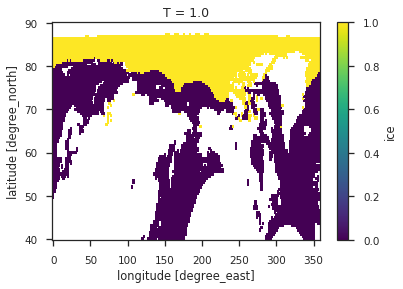

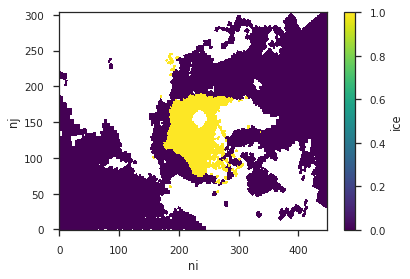

In [154]:
cmod = 'Xiaojun'

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/nicway/data/model/Xioajun/forecast/native/Yuan_Sep2019_Junedata_SIC_Arctic_native.nc'
    itstr = '2019-06-01'
elif r_yr_mon=='2019_July':
    sip_f=None
    itstr = '2019-07-01'
elif r_yr_mon=='2019_August':
    sip_f=None
    itstr = '2019-08-01'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    ds_user = xr.open_dataset(sip_f)
    
    da_in = ds_user.rename({'X':'lon','Y':'lat'}).isel(T=0).ice
    da_in = da_in/100
    # SIC to SIP
    da_in = (da_in>0.15).where(da_in.notnull())
    # Calculate regridding matrix
    regridder = xe.Regridder(da_in, obs_grid, method, periodic=True)
    # Regrid 
    da_out = regridder(da_in)
    # Remove weight file
    regridder.clean_weight_file() 
    da_in.plot()
    plt.figure()
    da_out.plot()
    # Store in dict of user submited SIP
    da_out.coords['model'] = cmod
    da_out = da_out.expand_dims('model')
    da_out.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                              dims='model', coords={'model':da_out.model})
    user_sip.append(da_out)

<xarray.Dataset>
Dimensions:    (time: 122, xaxis: 448, yaxis: 304)
Coordinates:
  * time       (time) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36
Dimensions without coordinates: xaxis, yaxis
Data variables:
    latitude   (xaxis, yaxis) float32 ...
    longitude  (xaxis, yaxis) float32 ...
    areacello  (xaxis, yaxis) float32 ...
    sftof      (xaxis, yaxis) uint8 ...
    siconc     (time, xaxis, yaxis) uint8 ...
Attributes:
    description:  NicoSun_SIPN_south_forecast_Mean


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


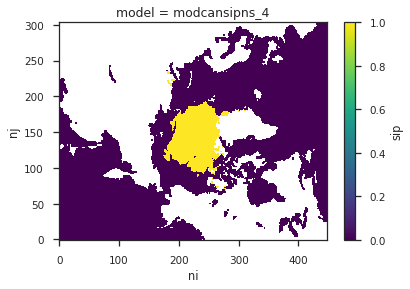

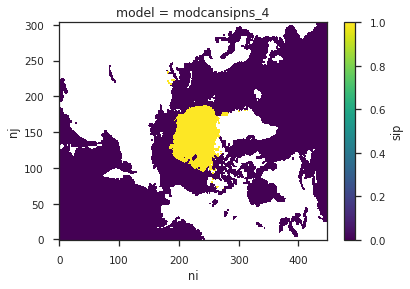

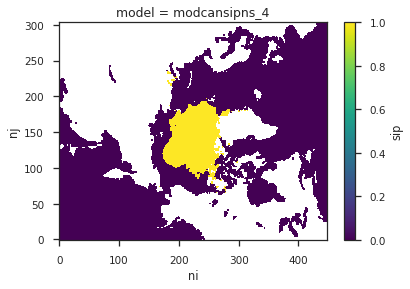

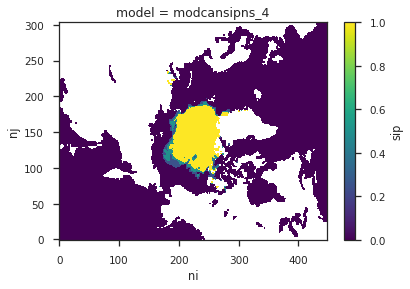

<Figure size 432x288 with 0 Axes>

In [155]:
cmod = 'nicosipn'

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/nicway/data/model/nicosipn/forecast/sipn_nc/NicoSun_2019_002_concentration.nc'
    sip_l = '/home/disk/sipn/nicway/data/model/nicosipn/forecast/sipn_nc/NicoSun_2019_001_concentration.nc'
    sip_h = '/home/disk/sipn/nicway/data/model/nicosipn/forecast/sipn_nc/NicoSun_2019_003_concentration.nc'
    itstr = '2019-06-01'
elif r_yr_mon=='2019_July':
    sip_f=None
    itstr = '2019-07-01'
    # must fix the slice in itime below for other months
elif r_yr_mon=='2019_August':
    sip_f=None
    itstr = '2019-08-01'
    # must fix the slice in itime below for other months
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    ds_user = xr.open_dataset(sip_f)
    print(ds_user)
    theland = ds_user.sftof  # nico land mask        
    ds_user = ds_user.siconc
    ds_user = ds_user.where(theland<50, other=np.nan)
    ds_user = ds_user.isel(time=slice(92,122))
    ds_user = ds_user.mean(dim='time')

    da = xr.DataArray(ds_user.values/100,dims=['ni','nj'])
    da=da.transpose('nj','ni')
    da.coords['lon'] = da_save.lon  # these are the lat and lon from can sips
    da.coords['lat'] = da_save.lat
    da.name = 'sip'
    da = (da>0.15).where(da.notnull())
    da_mean=da
    da.plot()
    plt.figure()
    
    ds_user = xr.open_dataset(sip_l)
    ds_user = ds_user.siconc
    ds_user = ds_user.where(theland<50, other=np.nan)
    ds_user = ds_user.isel(time=slice(92,122))
    ds_user = ds_user.mean(dim='time')
    
    da = xr.DataArray(ds_user.values/100,dims=['ni','nj'])
    da=da.transpose('nj','ni')
    da.coords['lon'] = da_save.lon  # these are the lat and lon from can sips
    da.coords['lat'] = da_save.lat
    da.name = 'sip'
    da = (da>0.15).where(da.notnull())
    da_low = da
    da.plot()
    plt.figure()

    ds_user = xr.open_dataset(sip_h)
    ds_user = ds_user.siconc
    ds_user = ds_user.where(theland<50, other=np.nan)
    ds_user = ds_user.isel(time=slice(92,122))
    ds_user = ds_user.mean(dim='time')
    
    da = xr.DataArray(ds_user.values/100,dims=['ni','nj'])
    da=da.transpose('nj','ni')
    da.coords['lon'] = da_save.lon  # these are the lat and lon from can sips
    da.coords['lat'] = da_save.lat
    da.name = 'sip'
    da = (da>0.15).where(da.notnull())
    da_high = da
    da.plot()
    plt.figure()
    
    da = da_high*0.25+da_mean*0.25+0.5*da_low
    #da = (da_low>0.5).where(da_low>0.5)

    da.plot()
    plt.figure()
    
    # Store in dict of user submited SIP
    # Store in dict of user submited SIP
    da.coords['model'] = cmod
    da = da.expand_dims('model')
    da.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                            dims='model', coords={'model':da.model})
    user_sip.append(da)

In [156]:
print(user_sip)

[<xarray.DataArray 'sip' (model: 1, nj: 304, ni: 448)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
    lon        (nj, ni) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (nj, ni) float64 31.1 31.25 31.4 31.55 ... 34.77 34.62 34.47
  * model      (model) <U13 'modcansipns_4'
    init_date  (model) datetime64[ns] 2019-06-01
Dimensions without coordinates: nj, ni
Attributes:
    regrid_method:  nearest_s2d, <xarray.DataArray 'sip' (model: 1, nj: 304, ni: 448)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]], dtype=float32)
Coordinates:
    lat        (nj, ni) float64 31.1 31.25 31.4 31.55 ... 34.77 34.62 34.47
  * model      (model) <U4 'gmao'
    lon        (nj, ni) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    init_date  

In [157]:
## Merge

In [158]:
usr_SIP = xr.concat(user_sip, dim='model')
usr_SIP = usr_SIP.rename({'nj':'x', 'ni':'y'})
usr_SIP.name = 'SIP'
usr_SIP

<xarray.DataArray 'SIP' (model: 8, x: 304, y: 448)>
dask.array<shape=(8, 304, 448), dtype=float64, chunksize=(1, 304, 448)>
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * model      (model) object 'modcansipns_4' 'gmao' ... 'Xiaojun' 'nicosipn'
    init_date  (model) datetime64[ns] dask.array<shape=(8,), chunksize=(1,)>
Dimensions without coordinates: x, y

### Loop through SIPN SIC data and plot those models that have forecasts through target month
- Use most recent init_time (if multiple)
- Use monthly sept mean SIC for each ensemble member to calculate SIP

In [159]:
# Define the last init day as the 11th of the current month's report (i.e. June would be the 13th of June)
last_init_day = np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth],13))
# Define the earliest init day as 1 year before last_init_day ( some models init on 1st of month (i.e. UCL))
first_init_day = last_init_day-np.timedelta64(365,'D')
first_init_day = last_init_day-np.timedelta64(90,'D')  # why a whole year rather than less?
print("Looking for init times between",first_init_day,"and",last_init_day)

Looking for init times between 2019-03-15T00:00:00.000000 and 2019-06-13T00:00:00.000000


In [160]:
# Define fig dir and make if doesn't exist
fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, cmonth)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
print('fig dir is ',fig_dir)

fig dir is  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2019/June


In [161]:
model_inits_used = {}
for cvar in variables:
    
    # Loop through variable of interest + any metrics (i.e. SIP) based on that
    for metric in metrics_all[cvar]:

        MME_list = []      
    
        # For each model
        for (i, cmod) in enumerate(models_2_plot):
            print("")
            print(cmod)

            # Load in Model data for just this year
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], 
                                          '*'+cyear+'*.nc') 

            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model

            start_time = timeit.default_timer()
            ds_model = xr.open_mfdataset(model_forecast, 
                        chunks={'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448}, 
                                         concat_dim='init_time', autoclose=True, parallel=True)
            ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
            ds_model=ds_model.sortby(ds_model.init_time)
            print("    Loading took  ", (timeit.default_timer() - start_time)/60, " minutes.")

            # Select var of interest (if available)
            if cvar in ds_model.variables:
                print('    cvar found ', cvar)
                ds_model = ds_model[cvar]
            else:
                print('    cvar not found.')
                continue
                  
            # Select init times
            
            # Use lagged ensemble
            if cmod in list(it_target_size.keys()): # Uses a lagged ensemble... so grab all inits and make them ensembles
                print('Using lagged ensemble')
                # NESM (Joe) wants us to use the past months inits (June for July report)
                if cmod == 'usnavysipn':
                    # Replace last_init_day inline below (note the "-1" meaning last month)
                    ds_model = ds_model.sel(init_time=slice(first_init_day,  np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth] - 1, 11))  )) # First get all time between start and stop (up to and including the 10th)
                else:
                    ds_model = ds_model.sel(init_time=slice(first_init_day,last_init_day)) # First get all time between start and stop (up to and including the 10th)
                
                if ds_model.init_time.size==0:
                    print("    No init_times found in requested start range",first_init_day,"to",last_init_day,". So skipping...")
                    continue
                    
                print("    Init times used are",ds_model.init_time[-1*it_target_size[cmod]:].values)    
                
                ds_model = ds_model.sel(init_time=ds_model.init_time[-1*it_target_size[cmod]:]) # Get nearest date to 10th
                avg_init_time = ds_model.init_time.astype('int').max().astype('datetime64[ns]')
                ds_model = ds_model.stack(hybrid_ensemble=('ensemble', 'init_time')).reset_index('hybrid_ensemble')
                ds_model.coords['hybrid_ensemble'] = np.arange(1,ds_model.hybrid_ensemble.size+1,1)
                ds_model = ds_model.drop(['ensemble','init_time'])
                ds_model.coords['init_time'] = avg_init_time
                ds_model = ds_model.rename({'hybrid_ensemble':'ensemble'})
                print(ds_model)

            # Normal Ensemble
            else:
                print('Using normal ensemble')
                # Find init time closest and earlier to the 10th of the month
                ds_model = ds_model.sel(init_time=slice(np.datetime64(first_init_day),np.datetime64(last_init_day))) # First get all time between start and stop (up to and including the 10th)
                print('   to these')
                print(ds_model.init_time)
                if ds_model.init_time.size==0:
                    print("    No init_times found in requested start range",first_init_day,"to",last_init_day,". So skipping...")
                    continue
                ds_model = ds_model.sel(init_time=last_init_day, method='nearest') # Get nearest date to 10th
            print("    Init time used is",ds_model.init_time.values)
                  
            # Get Valid time
            ds_model = import_data.get_valid_time(ds_model.expand_dims('init_time'))
                  
            # Check if we have any valid times in range of target dates
            ds_model = ds_model.where((ds_model.valid_time>=valid_start) & (ds_model.valid_time<=valid_end), drop=True) 
            if ds_model.fore_time.size == 0:
                print("    no fore_time found for target period.")
                continue
                 
            # Average over for_time
            ds_model = ds_model.mean(dim='fore_time')
            
            start_time = timeit.default_timer()
#                 print("Found data for model ", cmod, ". Plotting...")    
            if metric=='mean': # Calc ensemble mean
                ds_model = ds_model.mean(dim='ensemble')
            elif metric=='SIP': # Calc probability
                ok_ens = ((ds_model.notnull().sum(dim='x').sum(dim='y'))>0) # select ensemble members with any data
                ds_model = ((ds_model.where(ok_ens, drop=True)>=0.15) ).mean(dim='ensemble').where(ds_model.isel(ensemble=0).notnull())
            elif metric=='anomaly': # Calc anomaly in reference to mean observed 1980-2010
                ds_model = ds_model.mean(dim='ensemble') - da_obs_mean
                # Add back lat/long (get dropped because of round off differences)
                ds_model['lat'] = da_obs_mean.lat
                ds_model['lon'] = da_obs_mean.lon
            else:
                raise ValueError('metric not implemented')
            print("    Calc metric took  ", (timeit.default_timer() - start_time)/60, " minutes.")

            # Build MME
            if 'ensemble' in ds_model:
                ds_model = ds_model.drop('ensemble')
            if cmod not in MME_NO: # Exclude some models (bad) from MME
                ds_model.coords['model'] = cmod
                ds_model = ds_model.expand_dims('model')
                ds_model.coords['init_date'] = xr.DataArray(ds_model.init_time.values, dims='model', coords={'model':ds_model.model})
                MME_list.append(ds_model)
                # Store init time
                model_inits_used[cmod] = ds_model.init_time.values
                print('    Added ',cmod,' to MME.')

# Done with current it
print("Took ", (timeit.default_timer() - start_time)/60, " minutes.")

# Concat over all models
ds_MME = xr.concat(MME_list, dim='model')
ds_MME.name = 'SIP'


gfdlsipn
    Loading took   0.01138601200073026  minutes.
    cvar found  sic
Using normal ensemble
   to these
<xarray.DataArray 'init_time' (init_time: 3)>
array(['2019-04-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * init_time  (init_time) datetime64[ns] 2019-04-01 2019-05-01 2019-06-01
Attributes:
    comments:  Initilzation time of forecast
    Init time used is 2019-06-01T00:00:00.000000000
    Calc metric took   0.03157067543361336  minutes.
    Added  gfdlsipn  to MME.

ukmetofficesipn
    Loading took   0.015810193598736078  minutes.
    cvar found  sic
Using lagged ensemble
    Init times used are ['2019-05-12T00:00:00.000000000' '2019-05-13T00:00:00.000000000'
 '2019-05-14T00:00:00.000000000' '2019-05-15T00:00:00.000000000'
 '2019-05-16T00:00:00.000000000' '2019-05-17T00:00:00.000000000'
 '2019-05-18T00:00:00.000000000' '2019-05-19T00:00:00.000000000'
 '2019-05-20T00:00:00.000000000

In [162]:
# Convert to human readable
inits_hr = {}
for cmod, idate in model_inits_used.items():
    inits_hr[get_plot_title(cmod, custom_names, E)] = pd.to_datetime(model_inits_used[cmod]).strftime('%Y-%m-%d')[0]

In [163]:
inits_hr

{'AWI\nConsortium': '2019-06-07',
 'Met. Office': '2019-06-01',
 'NOAA GFDL': '2019-06-01',
 'Navy ESPC': '2019-05-10'}

In [164]:
# Take mean over init_time (different models init different times. mean doesn't change values)
model_inits = ds_MME.init_time # Save init_times
models_list = ds_MME.model
ds_MME = ds_MME.mean(dim='init_time')
ds_MME = ds_MME.drop(['ensemble'])
ds_MME

<xarray.DataArray 'SIP' (model: 4, x: 304, y: 448)>
dask.array<shape=(4, 304, 448), dtype=float64, chunksize=(1, 304, 448)>
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * model      (model) object 'gfdlsipn' 'ukmetofficesipn' ... 'awispin'
    init_date  (model) datetime64[ns] 2019-06-01 2019-06-01 ... 2019-06-07
Dimensions without coordinates: x, y

In [165]:
# Merge user SIP with SPIN SIP
ds_SIP_All = xr.concat([ds_MME,usr_SIP], dim='model')

In [166]:
# Load into memory
ds_SIP_All.load()

<xarray.DataArray 'SIP' (model: 12, x: 304, y: 448)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * model      (model) object 'gfdlsipn' 'ukmetofficesipn' ... 'nicosipn'
    init_date  (model) datetime64[ns] 2019-06-01 2019-06-01 ... 2019

In [167]:
# Save to disk
if not os.path.exists('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth):
    os.makedirs('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth)
ds_SIP_All.to_netcdf('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc')

In [168]:
# Load in last results
# ds_SIP_All = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc').SIP
# cvar = 'sic'
# metric = 'SIP'

In [169]:
ds_SIP_All

<xarray.DataArray 'SIP' (model: 12, x: 304, y: 448)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * model      (model) object 'gfdlsipn' 'ukmetofficesipn' ... 'nicosipn'
    init_date  (model) datetime64[ns] 2019-06-01 2019-06-01 ... 2019

In [170]:
# # Damped persistence trend has slightly different lat long (10^-6) so use lat lon from any other model here
# print("hack for bad lat lon in peristence, fix upstream!")
# ds_SIP_All['lat'] = ds_SIP_All.lat.sel(model='gfdlsipn').drop('model')

In [171]:
ds_MME_avg = ds_SIP_All.mean(dim='model')
ds_MME_std = ds_SIP_All.std(dim='model')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


gfdlsipn
ukmetofficesipn
usnavysipn
awispin
modcansipns_4
gmao
fgoalssipn
piomas
nmisipn
seansipn
Xiaojun
nicosipn
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2019/June/panArctic_SIP_forecast_2019_June_lowRES.png


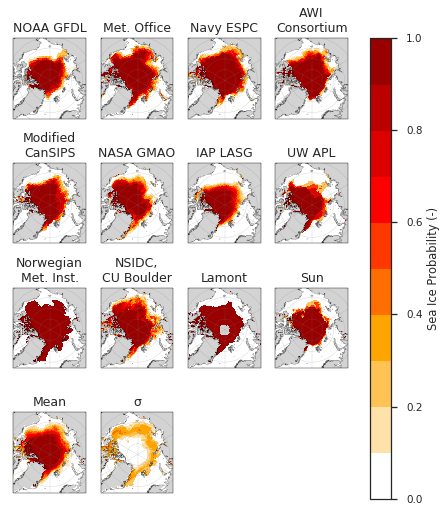

In [172]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1

elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=4, Nplots=15, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_SIP_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_SIP_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    add_subplot_title(cmod, custom_names, E, ax=axes[i])


# MME Mean
i = i + 1


pmme = ds_MME_avg.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('Mean')


# MME Standard deviation
i = i + 1


pmme = ds_MME_std.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('σ')
    

# Make pretty
f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.95, 0.06, 0.05, 0.8])
#cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
    if metric=='anomaly':
        cbar.set_ticks(np.arange(-1,1.1,0.2))
    else:
        cbar.set_ticks(np.arange(0,1.1,0.2))

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)



In [173]:
diehere
# the rest is for other months/ post season etc so force stop here

NameError: name 'diehere' is not defined

In [ ]:
# Compare past mean forecasts
ds_SIP_June = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+'2018'+'/'+'June'+'/SIP.nc')
ds_SIP_July = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+'2018'+'/'+'July'+'/SIP.nc')
ds_SIP_August = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+'2018'+'/'+'August'+'/SIP.nc')

In [ ]:
# July
# common_models = [x for x in ds_SIP_June.model.values if x not in ['awispin', 'nicosipn','ecmwfsipn']] # ecmwf not july, awi and nico no June
# August
common_models = [x for x in ds_SIP_August.model.values if x not in ['ecmwfsipn','GMAO']] # ecmwf and GMAO didn't submit aug

In [ ]:
# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=1, Nplots=20, extent=central_extent, central_longitude=0)

i = 0
pmme1 = ds_SIP_June.mean(dim='model').SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('June Multi\nModel Mean')

i = 1
pmme2 = ds_SIP_July.mean(dim='model').SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('July Multi\nModel Mean')

i = 2
pmme3 = ds_SIP_August.mean(dim='model').SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('August Multi\nModel Mean')


i = 3
cmap_diff = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red",])
cmap_diff.set_bad(color = 'lightgrey')
pmme3 = (ds_SIP_August.sel(model=common_models).mean(dim='model')-ds_SIP_July.sel(model=common_models).mean(dim='model')).SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_diff,vmin=-.2, vmax=.2)
axes[i].set_title('Difference\n(August - July)')


f.subplots_adjust(bottom=0.02)
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.08]) #  [left, bottom, width, height] w
cbar = f.colorbar(pmme2, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(np.arange(0,1.1,0.2))

cbar_ax_2 = f.add_axes([.93, 0.08, .025, 0.75]) #  [left, bottom, width, height] w
cbar2 = f.colorbar(pmme3, cax=cbar_ax_2, label='SIP Change (-)', orientation='vertical')

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_Aug_July_diff.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_Aug_July_diff_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [ ]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1

elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=4, Nplots=16, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_SIP_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_SIP_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    
    # Add init date
    axes[i].annotate(pd.to_datetime(ds_SIP_All.sel(model=cmod).init_date.values).strftime('%m/%d'), xy=(.6, -.13), xycoords='axes fraction', )
    


# MME Mean
i = i + 1
# f.delaxes(axes[i])
# i = i + 1
# f.delaxes(axes[i])
# i = i + 1

pmme = ds_MME_avg.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('Mean')


# MME Standard deviation
i = i + 1


pmme = ds_MME_std.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('σ')

# Difference from last SIO
i = i + 1
cmap_diff = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red",])
cmap_diff.set_bad(color = 'lightgrey')
pmme3 = (ds_SIP_August.sel(model=common_models).mean(dim='model')-ds_SIP_July.sel(model=common_models).mean(dim='model')).SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_diff,vmin=-.2, vmax=.2)
axes[i].set_title('Model-mean difference\n(August - July)')
    

# Make pretty
f.subplots_adjust(bottom=0.05)
# cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    if metric=='anomaly':
        cbar.set_ticks(np.arange(-1,1.1,0.2))
    else:
        cbar.set_ticks(np.arange(0,1.1,0.2))
        

# cbar_ax_2 = f.add_axes([0.93, 0.07, .025, .15]) #  [left, bottom, width, height] w
cbar_ax_2 = f.add_axes([0.715, 0.07, .025, .15]) #  [left, bottom, width, height] w

cbar2 = f.colorbar(pmme3, cax=cbar_ax_2, label='SIP Change (-)', orientation='vertical')


# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_withDiff.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_withDiff_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

## For Post-season, this figure overlays the observed ice iedge (>15%) on each model's SIP + std

In [ ]:
# Get Observed mean sea ice edge location mean(SIC in sept) > 0.15
cvar = 'sic'
metric = 'SIP'
obs_sept_SIP = ds_81[cvar].sel(time=slice(cyear+'-09-01',cyear+'-09-30')).mean(dim='time')>=0.15
# Fill in pole hole
obs_sept_SIP = obs_sept_SIP.where(obs_sept_SIP.hole_mask==0, other=1)
obs_sept_SIP.plot()

In [ ]:
c_ds = ds_SIP_June # pick month
c_ds

In [ ]:
# TESTING CONTOUR PLOT
# (f, axes) = ice_plot.polar_axis(extent=central_extent, central_longitude=0)


# pmme = c_ds[metric].mean(dim='model').plot.pcolormesh(ax=axes, x='lon', y='lat', 
#                                   transform=ccrs.PlateCarree(),
#                                   add_colorbar=False, 
#                                   cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)


# # pmme = obs_sept_SIP.plot.pcolormesh(ax=axes, x='lon', y='lat', 
# #                                   transform=ccrs.PlateCarree(),
# #                                   add_colorbar=False, 
# #                                   cmap='binary',vmin=c_vmin, vmax=c_vmax,
# #                                   alpha=0.1)



# po = obs_sept_SIP.plot.contour(ax=axes, x='xm', y='ym',
#                               transform=ccrs.NorthPolarStereo(central_longitude=-45),
#                               colors=('k'),
#                               linewidths=[3],
#                               levels=[0.5]) #, label='Median ice edge 1981-2010')
# ice_plot.remove_small_contours(po, thres=10**6)

In [ ]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1

elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=4, Nplots=14, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(c_ds.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = c_ds[metric].sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    
    
    
    po = obs_sept_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                                  transform=ccrs.NorthPolarStereo(central_longitude=-45),
                                  colors=('k'),
                                  linewidths=[1],
                                  levels=[0.5]) #, label='Median ice edge 1981-2010')
    ice_plot.remove_small_contours(po, thres=10**6)
    
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    
    # Add init date
    #axes[i].annotate(pd.to_datetime(c_ds.sel(model=cmod).init_date.values).strftime('%m/%d'), xy=(.6, -.13), xycoords='axes fraction', )
    


# MME Mean
i = i + 1
# f.delaxes(axes[i])
# i = i + 1
# f.delaxes(axes[i])
# i = i + 1

pmme = c_ds[metric].mean(dim='model').plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)

po = obs_sept_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                              transform=ccrs.NorthPolarStereo(central_longitude=-45),
                              colors=('k'),
                              linewidths=[1],
                              levels=[0.5]) #, label='Median ice edge 1981-2010')
ice_plot.remove_small_contours(po, thres=10**6)

axes[i].set_title('Mean')



# MME Standard deviation
i = i + 1


pmme = c_ds[metric].std(dim='model').plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)

po = obs_sept_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                              transform=ccrs.NorthPolarStereo(central_longitude=-45),
                              colors=('k'),
                              linewidths=[1],
                              levels=[0.5]) #, label='Median ice edge 1981-2010')
ice_plot.remove_small_contours(po, thres=10**6)

axes[i].set_title('σ')

                                                    
# Make pretty
# f.subplots_adjust(bottom=0.05)
# cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax = f.add_axes([0.35, 0.20, .5, 0.04]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    if metric=='anomaly':
        cbar.set_ticks(np.arange(-1,1.1,0.2))
    else:
        cbar.set_ticks(np.arange(0,1.1,0.2))
        

# cbar_ax_2 = f.add_axes([0.93, 0.07, .025, .15]) #  [left, bottom, width, height] w
# cbar_ax_2 = f.add_axes([0.715, 0.07, .025, .15]) #  [left, bottom, width, height] w

# cbar2 = f.colorbar(pmme3, cax=cbar_ax_2, label='SIP Change (-)', orientation='vertical')


# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_POSTSEASON.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_POSTSEASON_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

## Now plot BSS

In [ ]:
# Force round off lat/lon differences to be the same
obs_sept_SIP['lat'] = c_ds.lat
obs_sept_SIP['lon'] = c_ds.lon
ds_region['lat'] = c_ds.lat
ds_region['lon'] = c_ds.lon


In [ ]:
# Mask only to Arctic seas (importand to do this before spatially averaging!)
c_ds = c_ds.where(ds_region.mask.isin(ds_region.ocean_regions))
obs_sept_SIP = obs_sept_SIP.where(ds_region.mask.isin(ds_region.ocean_regions))

In [ ]:
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Brier Skill Score (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1

elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Brier Skill Score (-)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=3, Nplots=14, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(c_ds.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    c_BSS = ((c_ds[metric].sel(model=cmod)-obs_sept_SIP)**2)
    p = c_BSS.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    
    
    
    po = obs_sept_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                                  transform=ccrs.NorthPolarStereo(central_longitude=-45),
                                  colors=('k'),
                                  linewidths=[1],
                                  levels=[0.5]) #, label='Median ice edge 1981-2010')
    ice_plot.remove_small_contours(po, thres=10**6)
    
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    
    # Add init date
    

    axes[i].annotate('{0:.3f}'.format((c_BSS*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)),
                     xy=(.25, -.16), 
                     xycoords='axes fraction', )
    


# MME Mean
i = i + 1
# f.delaxes(axes[i])
# i = i + 1
# f.delaxes(axes[i])
# i = i + 1
c_BSS = ((c_ds[metric].mean(dim='model')-obs_sept_SIP)**2)
# Mask only to Arctic seas
pmme = c_BSS.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)

po = obs_sept_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
                              transform=ccrs.NorthPolarStereo(central_longitude=-45),
                              colors=('k'),
                              linewidths=[1],
                              levels=[0.5]) #, label='Median ice edge 1981-2010')
ice_plot.remove_small_contours(po, thres=10**6)

axes[i].set_title('Mean')

axes[i].annotate('{0:.3f}'.format((c_BSS*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)),
                     xy=(.25, -.16), 
                     xycoords='axes fraction', )



# # MME Standard deviation
# i = i + 1


# pmme = c_ds[metric].std(dim='model').plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
#                                   transform=ccrs.PlateCarree(),
#                                   add_colorbar=False, 
#                                   cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)

# po = obs_sept_SIP.plot.contour(ax=axes[i], x='xm', y='ym',
#                               transform=ccrs.NorthPolarStereo(central_longitude=-45),
#                               colors=('k'),
#                               linewidths=[1],
#                               levels=[0.5]) #, label='Median ice edge 1981-2010')
# ice_plot.remove_small_contours(po, thres=10**6)

# axes[i].set_title('σ')

                                                    
# Make pretty
f.subplots_adjust(bottom=0.05)
# cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    if metric=='anomaly':
        cbar.set_ticks(np.arange(-1,1.1,0.2))
    else:
        cbar.set_ticks(np.arange(0,1.1,0.2))
        

# cbar_ax_2 = f.add_axes([0.93, 0.07, .025, .15]) #  [left, bottom, width, height] w
# cbar_ax_2 = f.add_axes([0.715, 0.07, .025, .15]) #  [left, bottom, width, height] w

# cbar2 = f.colorbar(pmme3, cax=cbar_ax_2, label='SIP Change (-)', orientation='vertical')


# Save to file
f_out = os.path.join(fig_dir,'panArctic_BSS_'+runType+'_'+cyear+'_'+cmonth+'_POSTSEASON.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_BSS_'+runType+'_'+cyear+'_'+cmonth+'_POSTSEASON_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [ ]:
# Combine each month datset
ds_SIP_June['init'] = 'June'
ds_SIP_July['init'] = 'July'
ds_SIP_August['init'] = 'August'
ds_SIP_ALL = xr.concat([ds_SIP_June,ds_SIP_July,ds_SIP_August.drop('init_date')],dim='init')
ds_SIP_ALL

In [ ]:
(((c_ds[metric]-obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y']).values/(9.4*10**6)


In [ ]:
ds_SIP_ALL.model

In [ ]:
# Define colors/lines etce for each model to use in plots
cmap_c = itertools.cycle(sns.color_palette("Paired", len(E.model.keys()) ))
linecycler = itertools.cycle(["-","--","-.",":","--"])
markercycler = itertools.cycle(["*","o","s","v","X"])
mod_cc = {}
mod_ls = {}
mod_mk = {}
for (i, cmod) in enumerate(ds_SIP_ALL.model.values):
    mod_cc[cmod] = next(cmap_c)
    mod_ls[cmod] = next(linecycler)
    mod_mk[cmod] = next(markercycler)

In [ ]:
Inits_with_data = ds_SIP_ALL[metric].sel(model='Lamont\n(Yuan et al.)').notnull().sum(dim=['x','y'])>0

X = ((((ds_SIP_ALL[metric].sel(model='Lamont\n(Yuan et al.)') - obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y'])/(9.4*10**6)).where(Inits_with_data)
X.values

In [ ]:
# Plot for June, July, August, the mean BSS scores
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.set_style('whitegrid')
(f,ax) = plt.subplots(1,1)
f.set_size_inches((5,5))
for (i, cmod) in enumerate(ds_SIP_ALL.model.values):
    # Some models have msising inits, so remove those here (otherwise they sum to 0)
    Inits_with_data = ds_SIP_ALL[metric].sel(model=cmod).notnull().sum(dim=['x','y'])>0

    
    c_BSS = ((((ds_SIP_ALL[metric].sel(model=cmod) - obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y'])/(9.4*10**6)).where(Inits_with_data)
    ax.plot(c_BSS.init, c_BSS.values, 
            color=mod_cc[cmod],
            marker=mod_mk[cmod],
            linestyle=mod_ls[cmod],
            markersize=10,
            label=get_plot_title(cmod, custom_names, E))
# MME
MME_BSS = (((ds_SIP_ALL[metric].mean(dim='model') - obs_sept_SIP)**2)*ds_region.area).sum(dim=['x','y'])/(9.4*10**6)
ax.plot(MME_BSS.init, MME_BSS.values, label='Mean', linewidth=8)
f.legend(loc='lower right', bbox_to_anchor=(1.5, -0.04))
ax.set_ylim([0,0.18])
ax.set_ylabel('Brier Skill Score (-)')
ax.set_xlabel('Initialization month')

# Save to file
f_out = os.path.join(fig_dir,'panArctic_Mean_BSS_'+cyear+'_POSTSEASON.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_Mean_BSS_'+cyear+'_POSTSEASON_lowRes.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [ ]:
# Need to add check -- Compare June to July models (Make sure they are different! (unless they are supposed to be unchanged))